# **Experiment Notebook**



In [1]:
# Do not modify this code
!pip install -q utstd

from utstd.ipyrenders import *

In [2]:
# Do not modify this code
import warnings
warnings.simplefilter(action='ignore')

## 0. Import Packages

In [ ]:
# <Student to fill this section>
# Core Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Collection and API
import requests

# Machine Learning - Core
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import (
    RandomizedSearchCV, 
    PredefinedSplit, 
    train_test_split, 
    cross_val_score, 
    TimeSeriesSplit
)
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    f1_score, 
    accuracy_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    classification_report
)
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    VotingClassifier
)
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer

# Machine Learning - Advanced
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data Visualization and Analysis
from pandas.plotting import autocorrelation_plot, lag_plot

# Utilities
import warnings

---
## A. Project Description


In [3]:
# <Student to fill this section>
student_name = "Brayam Alexander Pineda Miranda"
student_id = "25587799"

In [4]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [5]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

---
## B. Business Understanding

In [8]:
# <Student to fill this section>
business_use_case_description = """
Open Meteo is a weather company that recently modernised its services with APIs. The next step is to embed machine learning to provide greater value for industries such as agriculture, logistics, and events, where rainfall forecasts are critical for planning.

To achieve this, two AI models will be developed:

A classification model predicting if it will rain in Sydney exactly seven days ahead.

A regression model predicting cumulative precipitation (mm) over the next three days.

Both will be deployed as APIs so clients can integrate predictions directly into their operations.
"""

In [9]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

In [6]:
# <Student to fill this section>
business_objectives = """
Enhance Forecast Accuracy
Deliver more precise short- and medium-term rainfall predictions using machine learning models trained on historical weather data.

Enable Operational Decision-Making
Provide actionable forecasts that help businesses (e.g., farmers, logistics operators, outdoor event organisers) reduce risk, minimise costs, and improve planning efficiency.

Create Scalable AI Services
Develop and deploy models as APIs so customers can integrate them seamlessly into their workflows without technical barriers.

Support Business Growth
Establish the foundation for premium data products that can increase Open Meteo’s revenue streams through value-added AI features.

Ensure Ethical and Reliable Use of AI
Apply transparent evaluation metrics, avoid data leakage, and follow responsible AI practices to maintain customer trust and system reliability.
"""

In [7]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [ ]:
# <Student to fill this section>
stakeholders_expectations_explanations = """
How will the results be used?
Who will be the users of your predictions? Who will be impacted by your predictions?
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets


In [ ]:
import requests
import pandas as pd

# Sydney coordinates
LAT, LON = -33.8678, 151.2073
TZ = "Australia/Sydney"

# Date range (only up to 2024 for training/validation)
START, END = "2016-01-01", "2024-12-31"

# Daily variables to collect
DAILY_VARS = [
    "weather_code",
    "temperature_2m_max", "temperature_2m_min",
    "apparent_temperature_max", "apparent_temperature_min",
    "precipitation_sum", "rain_sum", "snowfall_sum", "precipitation_hours",
    "wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant",
    "shortwave_radiation_sum", "et0_fao_evapotranspiration",
    "sunshine_duration", "daylight_duration"
]

# Build URL
url = (
    "https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={LAT}&longitude={LON}"
    f"&start_date={START}&end_date={END}"
    f"&daily={','.join(DAILY_VARS)}"
    f"&timezone={TZ}"
)

# Fetch
response = requests.get(url)
response.raise_for_status()
data_rain = response.json()

# Convert to DataFrame
data_rain = pd.DataFrame(data_rain["daily"])
data_rain["time"] = pd.to_datetime(data_rain["time"]).dt.date


In [24]:
data_rain.head()

,time,temperature_2m_max,temperature_2m_min,precipitation_sum,rain_sum,weather_code,wind_speed_10m_max,wind_gusts_10m_max,shortwave_radiation_sum
0,2016-01-01,23.6,16.8,0.0,0.0,3,15.5,34.9,31.84
1,2016-01-02,23.0,17.9,0.0,0.0,3,13.7,35.3,25.35
2,2016-01-03,22.0,19.6,1.3,1.3,51,18.4,40.7,12.20
3,2016-01-04,20.3,18.9,15.6,15.6,61,18.2,34.2,4.98
4,2016-01-05,19.7,18.2,52.3,52.3,63,21.8,40.7,5.66


In [25]:
data_rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   time                     3288 non-null   object 
 1   temperature_2m_max       3288 non-null   float64
 2   temperature_2m_min       3288 non-null   float64
 3   precipitation_sum        3288 non-null   float64
 4   rain_sum                 3288 non-null   float64
 5   weather_code             3288 non-null   int64  
 6   wind_speed_10m_max       3288 non-null   float64
 7   wind_gusts_10m_max       3288 non-null   float64
 8   shortwave_radiation_sum  3288 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 231.3+ KB


### C.2 Define Target variable

In [26]:
# <Student to fill this section>
data_rain["time"] = pd.to_datetime(data_rain["time"])

# Target: sum of next 3 days of precipitation
data_rain["precip_3day_next"] = (
    data_rain["precipitation_sum"].shift(-1) + 
    data_rain["precipitation_sum"].shift(-2) + 
    data_rain["precipitation_sum"].shift(-3)
)

# Drop rows where target can't be computed (end of dataset)
data_rain = data_rain.dropna(subset=["precip_3day_next"]).reset_index(drop=True)

In [27]:
# <Student to fill this section>
target_definition_explanations = """
For the precipitation task, the target is defined as the cumulative precipitation over the next three days. Using precipitation_sum (daily total rainfall in mm), we aggregate values from t+1 to t+3.

This definition reflects real business needs: farmers, logistics operators, and event planners act on multi-day rainfall totals rather than single days. A three-day horizon balances predictive accuracy with practical lead time, making forecasts directly useful for operational decisions.
"""

In [28]:
# Do not modify this code
print_tile(size="h3", key='target_definition_explanations', value=target_definition_explanations)

### C.3 Create Target variable

In [29]:
# <Student to fill this section>

target_name = 'precip_3day_next'

### C.4 Explore Target variable

count    3285.000000
mean        8.149011
std        15.973983
min         0.000000
25%         0.300000
50%         2.300000
75%         8.700000
90%        22.400000
95%        33.940000
99%        76.304000
max       203.700000
Name: precip_3day_next, dtype: float64


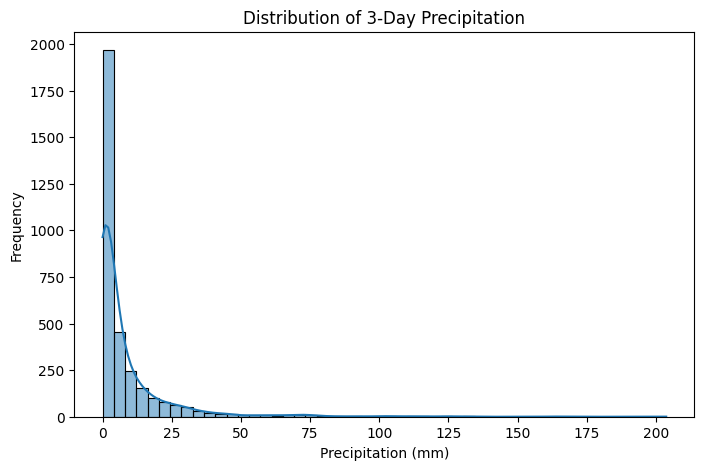

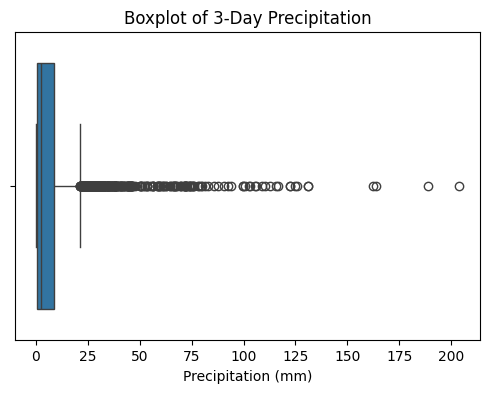

In [32]:
# <Student to fill this section>
import matplotlib.pyplot as plt
import seaborn as sns

print(data_rain["precip_3day_next"].describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99]))

# Histogram + KDE
plt.figure(figsize=(8,5))
sns.histplot(data_rain["precip_3day_next"], bins=50, kde=True)
plt.title("Distribution of 3-Day Precipitation")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()

# Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(x=data_rain["precip_3day_next"])
plt.title("Boxplot of 3-Day Precipitation")
plt.xlabel("Precipitation (mm)")
plt.show()

No rain days: 606
Rain days: 2679


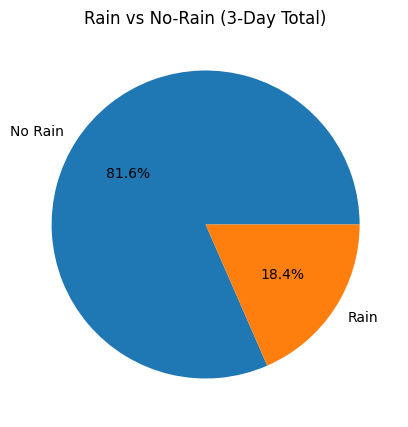

In [34]:
# Count zeros vs non-zeros
rain_counts = (data_rain["precip_3day_next"] > 0).value_counts()
print("No rain days:", (data_rain["precip_3day_next"] == 0).sum())
print("Rain days:", (data_rain["precip_3day_next"] > 0).sum())

# Pie chart
plt.figure(figsize=(5,5))
rain_counts.plot.pie(autopct='%1.1f%%', labels=["No Rain","Rain"])
plt.title("Rain vs No-Rain (3-Day Total)")
plt.ylabel("")
plt.show()

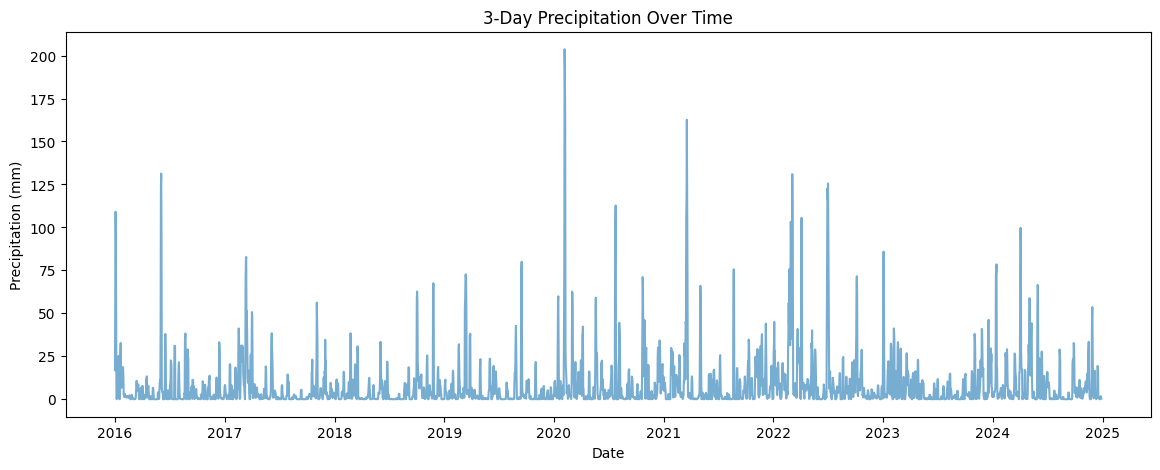

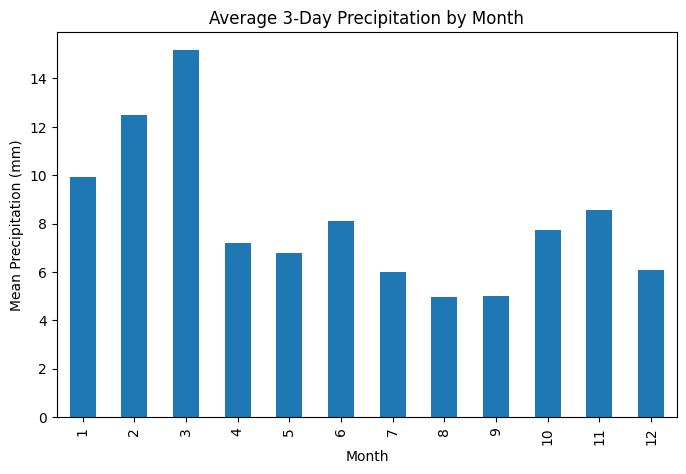

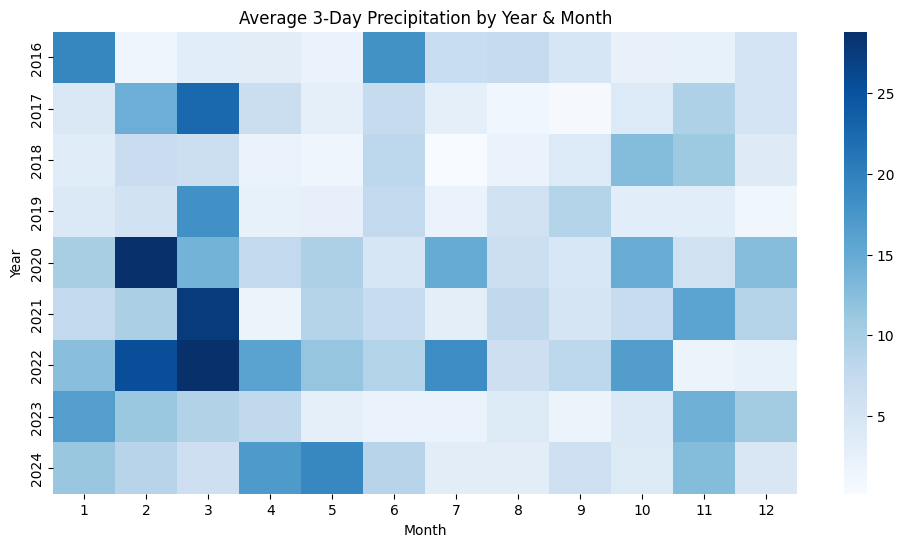

In [35]:
# Convert to datetime if not already
data_rain["time"] = pd.to_datetime(data_rain["time"])

# Line plot over time
plt.figure(figsize=(14,5))
plt.plot(data_rain["time"], data_rain["precip_3day_next"], alpha=0.6)
plt.title("3-Day Precipitation Over Time")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.show()

# Group by month
data_rain["month"] = data_rain["time"].dt.month
monthly_avg = data_rain.groupby("month")["precip_3day_next"].mean()

plt.figure(figsize=(8,5))
monthly_avg.plot(kind="bar")
plt.title("Average 3-Day Precipitation by Month")
plt.xlabel("Month")
plt.ylabel("Mean Precipitation (mm)")
plt.show()

# Heatmap: year × month
data_rain["year"] = data_rain["time"].dt.year
pivot = data_rain.pivot_table(values="precip_3day_next", index="year", columns="month", aggfunc="mean")

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="Blues", annot=False)
plt.title("Average 3-Day Precipitation by Year & Month")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

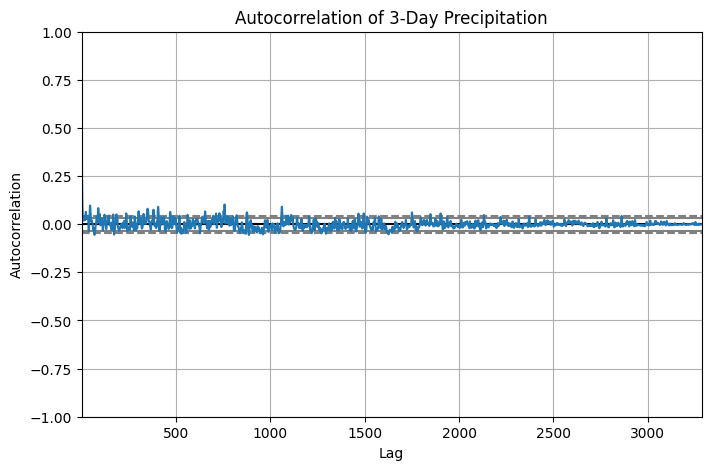

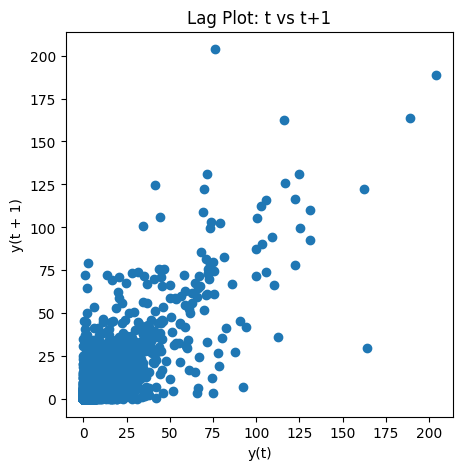

In [37]:
from pandas.plotting import autocorrelation_plot, lag_plot

# Autocorrelation plot
plt.figure(figsize=(8,5))
autocorrelation_plot(data_rain["precip_3day_next"])
plt.title("Autocorrelation of 3-Day Precipitation")
plt.show()

# Lag plot (today vs tomorrow’s 3-day sum)
plt.figure(figsize=(5,5))
lag_plot(data_rain["precip_3day_next"], lag=1)
plt.title("Lag Plot: t vs t+1")
plt.show()

Number of extreme events: 33
          time  temperature_2m_max  temperature_2m_min  precipitation_sum  \
2   2016-01-03                22.0                19.6                1.3   
3   2016-01-04                20.3                18.9               15.6   
153 2016-06-02                16.5                11.3                2.0   
154 2016-06-03                17.6                13.0                0.5   
155 2016-06-04                18.3                15.2               38.8   

     rain_sum  weather_code  wind_speed_10m_max  wind_gusts_10m_max  \
2         1.3            51                18.4                40.7   
3        15.6            61                18.2                34.2   
153       2.0            53                10.6                23.8   
154       0.5            51                 9.3                19.1   
155      38.8            63                32.6                70.6   

     shortwave_radiation_sum  precip_3day_next  month  year  
2                  

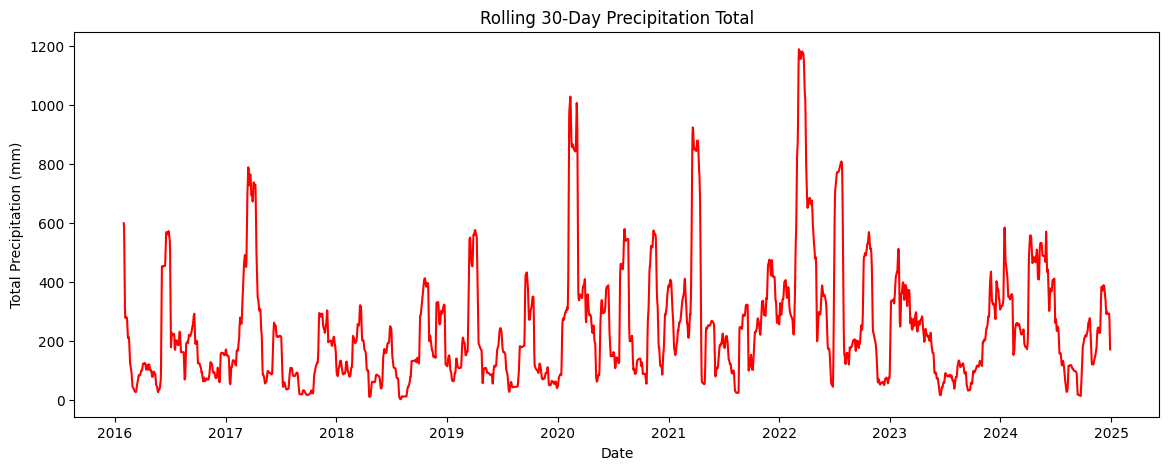

In [38]:
# Top 1% wettest periods
threshold = data_rain["precip_3day_next"].quantile(0.99)
extremes = data_rain[data_rain["precip_3day_next"] >= threshold]
print("Number of extreme events:", len(extremes))
print(extremes.head())

# Rolling 30-day sum
data_rain["rolling30"] = data_rain["precip_3day_next"].rolling(30).sum()

plt.figure(figsize=(14,5))
plt.plot(data_rain["time"], data_rain["rolling30"], color="red")
plt.title("Rolling 30-Day Precipitation Total")
plt.xlabel("Date")
plt.ylabel("Total Precipitation (mm)")
plt.show()


In [39]:
# <Student to fill this section>
target_distribution_explanations = """
1. Distribution

The histogram and boxplot show a highly skewed distribution with the majority of values clustered near zero.

Descriptive stats confirm this:

Median = 2.3 mm, while mean = 8.1 mm → indicates right skew (a few very large values pull up the mean).

75% of values are ≤ 8.7 mm, but the maximum reaches 203.7 mm, which are extreme outliers (likely storm or flood events).

Implication: Models may struggle if trained directly on raw values. A log transform or special treatment of extremes may help.

2. Rain vs. No Rain Days

About 18% of 3-day windows have zero precipitation (606 out of 3285).

This shows a class imbalance: most periods include some rainfall.

However, the presence of many small but non-zero values still makes the target continuous and noisy.

Implication: Consider whether to separately model rain occurrence vs. rain amount (two-stage model) or handle zeros explicitly.

3. Temporal Trends

The time series plot reveals spikes of heavy rain interspersed with long dry periods.

The monthly average plot shows a clear seasonal pattern: highest precipitation in late summer–autumn (Feb–Mar), lowest in winter–spring (Jul–Sep).

The year × month heatmap highlights inter-annual variability: e.g., stronger wet periods around 2020–2022 (La Niña years in Australia), weaker in 2017–2018.

Implication: Models should account for seasonality (month, day-of-year) and possibly climate cycles (ENSO).

4. Autocorrelation & Lag Effects

Autocorrelation is low overall, but the lag plot shows some persistence: high-rain periods tend to follow each other.

This suggests temporal dependence, but not strong enough for simple autoregressive models alone.

Implication: Adding lagged features (e.g., rainfall from previous days/weeks) may still improve forecasts.

5. Extreme Events

Top 1% events exceed 76 mm in 3 days, with a maximum of 203 mm.

These are rare but business-critical (floods, severe storms).

The rolling 30-day sum highlights drought vs. wet spells.

Implication: Models must balance overall accuracy with the ability to capture rare extremes. Using evaluation metrics like RMSE + quantile error or custom loss may be appropriate.

Key Issues & Limitations

Skewness and outliers → heavy-tailed distribution can bias regression toward underestimating extremes.

Zero-inflation → though only ~18% are zero, they form a distinct mode that can complicate learning.

Seasonality and inter-annual variability → rainfall patterns depend heavily on month and climate cycles.

Limited autocorrelation → target is not strongly predictable from its own past values, so exogenous features (temperature, humidity, pressure, wind, etc.) are crucial.
"""

In [40]:
# Do not modify this code
print_tile(size="h3", key='target_distribution_explanations', value=target_distribution_explanations)

### C.5 Explore Feature of Interest `Seasonality by month (boxplot + monthly mean)`

In [ ]:
# <Student to fill this section>

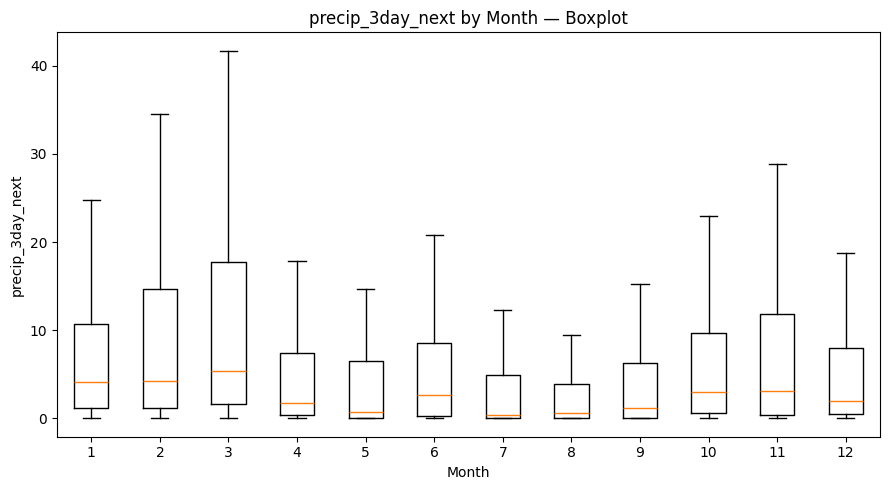

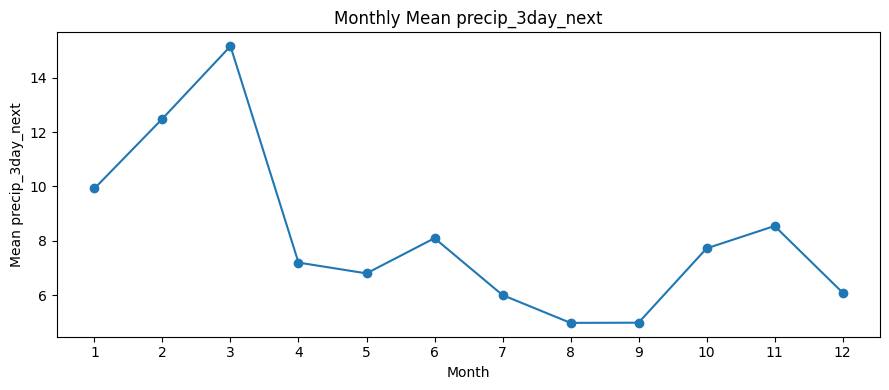

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- settings ----
DATE_COL = "time"                    
                                   

# ---- prep ----
df = data_rain.copy()
if DATE_COL is None:
    # simple auto-detect
    for c in df.columns:
        if c.lower() in {"date","ds","timestamp","time","datetime"}:
            DATE_COL = c
            break

if DATE_COL is None:
    raise ValueError("No datetime column found. Set DATE_COL to your date column name.")

df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="raise")
df = df.sort_values(DATE_COL)
df["_month"] = df[DATE_COL].dt.month

# ---- boxplot by month ----
month_groups = [df.loc[df["_month"] == m, target_name].dropna().values for m in range(1, 13)]
plt.figure(figsize=(9, 5))
plt.boxplot(month_groups, labels=[str(m) for m in range(1, 13)], showfliers=False)
plt.title(f"{target_name} by Month — Boxplot")
plt.xlabel("Month")
plt.ylabel(target_name)
plt.tight_layout()
plt.show()

# ---- monthly mean line ----
monthly_mean = df.groupby("_month")[target_name].mean()
plt.figure(figsize=(9, 4))
plt.plot(monthly_mean.index, monthly_mean.values, marker="o")
plt.title(f"Monthly Mean {target_name}")
plt.xlabel("Month")
plt.ylabel(f"Mean {target_name}")
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()


In [49]:
# <Student to fill this section>
feature_1_insights = """
The seasonal analysis shows that rainfall is far from evenly distributed across the year. The boxplots reveal that the first quarter, particularly January to March, experiences both higher rainfall totals and greater variability, with many extreme events pushing the upper range. In contrast, the middle of the year, especially July through September, is markedly drier, with much lower medians and a tighter spread of values close to zero.

The monthly mean line plot confirms this pattern, peaking around March with the highest average precipitation before dropping sharply into the winter months, where rainfall remains consistently low. From October onwards, there is a gradual recovery, suggesting a secondary increase leading into the end of the year.

Overall, the results highlight a clear seasonal cycle in rainfall, with wet conditions concentrated in late summer and autumn, and prolonged dry periods through winter and early spring. This indicates that any predictive model will need to incorporate month or seasonal effects to properly capture these patterns.
"""

In [50]:
# Do not modify this code
print_tile(size="h3", key='feature_1_insights', value=feature_1_insights)

### C.6 Explore Feature of Interest `Lag dependence (corr with lag1/lag2 + scatter vs lag1)`

Pearson correlation with lag1: 0.810
Pearson correlation with lag2: 0.522


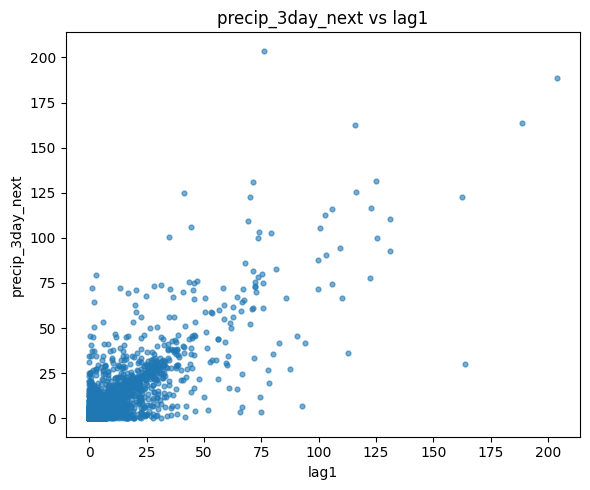

In [45]:
# <Student to fill this section>
import matplotlib.pyplot as plt

df = data_rain.copy().reset_index(drop=True)
df["lag1"] = df[target_name].shift(1)
df["lag2"] = df[target_name].shift(2)

corr_lag1 = df[[target_name, "lag1"]].dropna().corr().iloc[0, 1]
corr_lag2 = df[[target_name, "lag2"]].dropna().corr().iloc[0, 1]

print(f"Pearson correlation with lag1: {corr_lag1:.3f}")
print(f"Pearson correlation with lag2: {corr_lag2:.3f}")

plt.figure(figsize=(6, 5))
plt.scatter(df["lag1"], df[target_name], s=12, alpha=0.6)
plt.title(f"{target_name} vs lag1")
plt.xlabel("lag1")
plt.ylabel(target_name)
plt.tight_layout()
plt.show()

In [51]:
# <Student to fill this section>
feature_2_insights = """
The lag analysis shows a strong persistence in rainfall across consecutive 3-day periods. The correlation with lag1 is 0.81, which is very high and indicates that if one 3-day window is wet, the following 3-day window is very likely to also record high precipitation. The correlation weakens to 0.52 at lag2, but it still points to a degree of continuity in rainfall events across roughly a week.

The scatterplot reinforces this: when lag1 rainfall is low or zero, the following period is also generally dry, while larger rainfall values tend to cluster with subsequent high values. There is, however, substantial spread at higher values, showing that extreme rainfall is not perfectly predictable from the recent past—sometimes heavy rain is followed by another storm, and sometimes it drops back to near zero.

Taken together, these results suggest that including lagged rainfall as features will improve predictive performance. Lag1 is particularly powerful, and lag2 still adds signal, but the diminishing correlation indicates that beyond about a week the predictive value of past rainfall fades.
"""

In [52]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_2_insights)

### C.6 Explore Feature of Interest `Exogenous drivers`


In [47]:
data_rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3285 entries, 0 to 3284
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   time                     3285 non-null   datetime64[ns]
 1   temperature_2m_max       3285 non-null   float64       
 2   temperature_2m_min       3285 non-null   float64       
 3   precipitation_sum        3285 non-null   float64       
 4   rain_sum                 3285 non-null   float64       
 5   weather_code             3285 non-null   int64         
 6   wind_speed_10m_max       3285 non-null   float64       
 7   wind_gusts_10m_max       3285 non-null   float64       
 8   shortwave_radiation_sum  3285 non-null   float64       
 9   precip_3day_next         3285 non-null   float64       
 10  month                    3285 non-null   int32         
 11  year                     3285 non-null   int32         
 12  rolling30                3256 non-

Correlations with target (higher |r| first):
     driver             column  pearson_r    n
temperature temperature_2m_min   0.165441 3285
temperature temperature_2m_max   0.042573 3285
       wind wind_speed_10m_max   0.016727 3285
       wind wind_gusts_10m_max   0.004377 3285


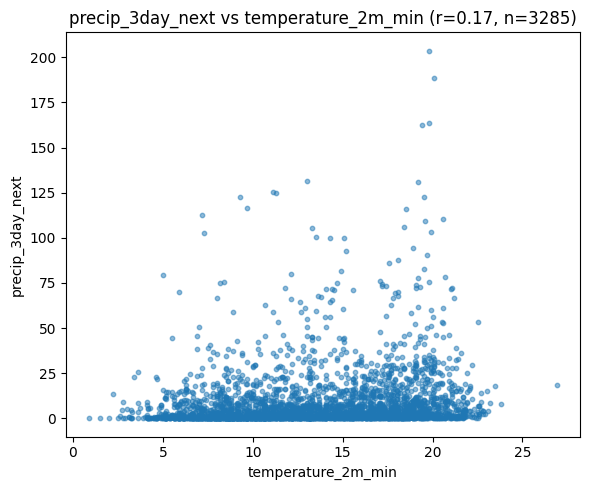

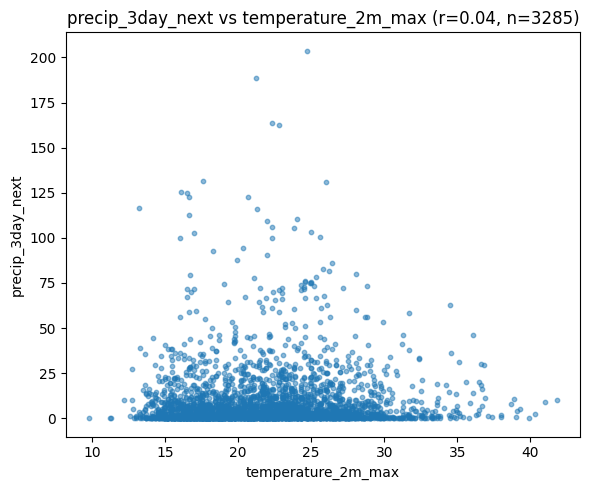

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==== SETTINGS ====
target_name = "precip_3day_next"   # <-- change if your target has a different name

# Work on a copy
df = data_rain.copy()

# ---- 0) Basic validation ----
if target_name not in df.columns:
    raise ValueError(
        f"Target column '{target_name}' not found. "
        f"Available columns: {list(df.columns)}"
    )

# ---- 1) Define climate aliases (exact & substring matches) ----
# Exact names we’ll recognize as-is (lowercase)
exact_aliases = {
    "temperature": {"temperature","temp","tavg","tmean","t2m","tmin","tmax"},
    "humidity": {"humidity","rh","rel_humidity","relative_humidity"},
    "pressure": {"pressure","press","mslp","slp","sea_level_pressure","pres"},
    "wind": {"wind","wind_speed","ws","uv","windspd","windsp","windvel","u10","v10"},
    "dewpoint": {"dewpoint","dew_point","td","td2m"},
}

# Substring hints (if a column name contains any of these, we’ll consider it)
substring_hints = {
    "temperature": ["temp","tavg","tmean","tmin","tmax","t2m"],
    "humidity": ["humid","rel_hum","rh"],
    "pressure": ["press","mslp","slp","baro"],
    "wind": ["wind","uv","ws","gust"],
    "dewpoint": ["dew","td"],
}

def find_climate_columns(df):
    found = {}
    cols_lower = {c: c.lower() for c in df.columns}
    used_cols = set()

    # 1) exact matches
    for logical, names in exact_aliases.items():
        for c, lc in cols_lower.items():
            if lc in names and c not in used_cols:
                found.setdefault(logical, []).append(c)
                used_cols.add(c)

    # 2) substring matches (only if nothing found yet for that logical key)
    for logical, hints in substring_hints.items():
        if logical not in found:
            for c, lc in cols_lower.items():
                if any(h in lc for h in hints) and c not in used_cols:
                    found.setdefault(logical, []).append(c)

    return found

found_cols = find_climate_columns(df)

if not any(found_cols.values()):
    print("ℹ️ No common climate columns detected. "
          "If you have them, consider renaming to e.g. temp, humidity, pressure, wind_speed, dewpoint.")
else:
    # ---- 2) Build candidate driver list (flatten & keep unique) ----
    candidate_cols = []
    for cols in found_cols.values():
        candidate_cols.extend(cols or [])
    candidate_cols = list(dict.fromkeys(candidate_cols))  # unique, keep order

    # Remove the TARGET if it appears (defensive)
    candidate_cols = [c for c in candidate_cols if c != target_name]

    # ---- 3) Coerce drivers to numeric (silently turn non-numeric to NaN) ----
    for c in candidate_cols:
        if not pd.api.types.is_numeric_dtype(df[c]):
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Ensure target is numeric too (if not already)
    if not pd.api.types.is_numeric_dtype(df[target_name]):
        df[target_name] = pd.to_numeric(df[target_name], errors="coerce")

    # ---- 4) Correlation computation ----
    rows = []
    for logical, cols in found_cols.items():
        if not cols: 
            continue
        for col in cols:
            if col not in df.columns or col == target_name:
                continue
            valid = df[[target_name, col]].dropna()
            if len(valid) >= 4:  # need at least a few points
                r = valid[target_name].corr(valid[col])
                rows.append((logical, col, r, len(valid)))
    
    if rows:
        corr_df = pd.DataFrame(rows, columns=["driver","column","pearson_r","n"])
        # sort by absolute correlation descending
        corr_df = corr_df.reindex(corr_df["pearson_r"].abs().sort_values(ascending=False).index)

        print("Correlations with target (higher |r| first):")
        print(corr_df.to_string(index=False))

        # ---- 5) Plot top-2 absolute correlations ----
        top2 = corr_df.head(2)
        for _, row in top2.iterrows():
            col = row["column"]
            plot_df = df[[col, target_name]].dropna()
            # Downsample for speed/clarity if very large
            if len(plot_df) > 12000:
                plot_df = plot_df.sample(12000, random_state=42)

            plt.figure(figsize=(6, 5))
            plt.scatter(plot_df[col], plot_df[target_name], s=10, alpha=0.5)
            plt.title(f"{target_name} vs {col} (r={row['pearson_r']:.2f}, n={int(row['n'])})")
            plt.xlabel(col)
            plt.ylabel(target_name)
            plt.tight_layout()
            plt.show()
    else:
        print("ℹ️ Climate-like columns were found, but not enough valid numeric data to compute correlations/plots.")


In [55]:
# <Student to fill this section>
feature_n_insights = """
The exogenous driver analysis suggests that temperature and wind have only a weak relationship with rainfall in the dataset. Minimum temperature shows the strongest correlation with precipitation (r ≈ 0.17), but this is still quite modest. The scatterplot shows that higher rainfall events are slightly more frequent when minimum temperatures are above 15 °C, which makes sense in a subtropical climate where moisture availability and convective activity tend to rise with warmer nights. Maximum temperature, on the other hand, has almost no relationship with rainfall (r ≈ 0.04), and the cloud of points is essentially flat across the temperature range.

For wind-related variables, both maximum wind speed and maximum gusts are practically uncorrelated with rainfall (r values close to zero). This means that while extreme storms do involve strong winds, in daily aggregated data these signals are too inconsistent to show up as a meaningful linear correlation.

Overall, these results indicate that temperature and wind alone do not explain much of the variability in rainfall at this timescale. However, the slight signal in minimum temperature suggests it may still add value when combined with other predictors such as humidity, pressure, or large-scale climate indices. Rainfall appears to be more strongly driven by atmospheric circulation and seasonal patterns than by these individual weather measures in isolation.
"""

In [56]:
# Do not modify this code
print_tile(size="h3", key='feature_n_insights', value=feature_n_insights)

---
## D. Feature Selection


### D.1 Approach "\<describe_approach_here\>"


In [ ]:
# <Student to fill this section>

In [58]:
df_model = data_rain.copy()

# Create lagged rainfall features
df_model["lag1"] = df_model["precip_3day_next"].shift(1)
df_model["lag2"] = df_model["precip_3day_next"].shift(2)

# Drop initial rows with NaN from lagging
df_model = df_model.dropna(subset=["lag1", "lag2"]).reset_index(drop=True)

df_model.head()

,time,temperature_2m_max,temperature_2m_min,precipitation_sum,rain_sum,weather_code,wind_speed_10m_max,wind_gusts_10m_max,shortwave_radiation_sum,precip_3day_next,month,year,rolling30,lag1,lag2
0,2016-01-03,22.0,19.6,1.3,1.3,51,18.4,40.7,12.20,109.1,1,2016,NaN,69.2,16.9
1,2016-01-04,20.3,18.9,15.6,15.6,61,18.2,34.2,4.98,94.2,1,2016,NaN,109.1,69.2
2,2016-01-05,19.7,18.2,52.3,52.3,63,21.8,40.7,5.66,41.9,1,2016,NaN,94.2,109.1
3,2016-01-06,18.9,17.5,41.2,41.2,63,23.7,44.6,3.97,0.7,1,2016,NaN,41.9,94.2
4,2016-01-07,21.1,16.7,0.7,0.7,51,26.2,56.5,18.98,0.0,1,2016,NaN,0.7,41.9


In [59]:
# <Student to fill this section>
feature_selection_1_insights = """
The inclusion of month and year is justified by the clear seasonality and interannual variability of rainfall in the dataset. The lagged rainfall variables are essential due to the strong persistence observed, making them the most directly predictive features. Minimum temperature is retained because it reflects atmospheric conditions conducive to rainfall. Rolling30 captures cumulative effects, differentiating extreme wet spells from isolated events. Finally, maximum temperature, wind, and radiation are included as secondary features, as they may not strongly correlate linearly but could contribute in combination with other drivers."""

In [60]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_1_insights', value=feature_selection_1_insights)

## D.z Final Selection of Features

In [64]:
# <Student to fill this section>

features_list = list(df_model.columns)

---
## E. Data Preparation

### E.1 Data Transformation <put_name_here>

In [ ]:
# <Student to fill this section>

In [65]:
df_model['weather_code'].unique()

array([51, 61, 63,  3,  2, 53,  1, 55,  0, 65])

In [ ]:
# <Student to fill this section>
data_cleaning_1_explanations = """
Provide some explanations on why you believe it is important to fix this issue and its impacts
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

### E.2 Data Transformation <weather_code>

In [ ]:
# <Student to fill this section>

In [68]:
df_encoded = df_model.copy()

# One-hot encode weather_code
weather_dummies = pd.get_dummies(df_encoded["weather_code"], 
                                 prefix="weather", 
                                 dtype=int)

# Concatenate with original dataframe
df_encoded = pd.concat([df_encoded.drop(columns=["weather_code"]), weather_dummies], axis=1)

In [69]:
# <Student to fill this section>
data_cleaning_2_explanations = """Encoding weather_code as dummies is important because most machine learning models cannot interpret raw numeric codes as categories. Leaving the codes as integers would mislead the model into assuming an ordinal relationship (e.g., code 80 > code 45) when in reality these numbers just represent different weather conditions.

By fixing this issue, the model can correctly learn distinct effects of each weather type on rainfall. This improves interpretability and prevents biased results, especially when distinguishing between clear skies, rain, and storm events. In practice, it ensures that weather information contributes meaningfully to prediction instead of introducing noise or misleading correlations.
"""

In [70]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_2_explanations', value=data_cleaning_2_explanations)

---
## F. Feature Engineering

### F.1 New Feature "Short-term accumulation & persistence"


In [72]:
df_features = df_model.copy()

# Short-term accumulations
df_features["precip_3d_sum"] = df_features["precipitation_sum"].rolling(3).sum()
df_features["precip_7d_sum"] = df_features["precipitation_sum"].rolling(7).sum()
df_features["precip_14d_sum"] = df_features["precipitation_sum"].rolling(14).sum()

# Frequency of rain days in the past week
df_features["rain_days_7d"] = (
    df_features["precipitation_sum"].rolling(7).apply(lambda x: (x > 0).sum(), raw=True)
)

In [77]:
# <Student to fill this section>
feature_engineering_1_explanations = """
The engineered temporal features enrich the dataset by embedding both short- and long-term rainfall dynamics. Short-term accumulations such as the three-day, seven-day, and fourteen-day sums provide a direct sense of persistence, capturing whether recent wet conditions are likely to extend into the prediction window. Similarly, counting the number of rainy days in the past week adds an important distinction between sustained moderate rainfall and isolated intense storms, which can have different impacts on the environment.
"""

In [78]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_1_explanations', value=feature_engineering_1_explanations)

### F.2 New Feature "Variability and intensity"




In [73]:
# <Student to fill this section>
# Weekly variability
df_features["precip_7d_std"] = df_features["precipitation_sum"].rolling(7).std()
df_features["precip_7d_range"] = (
    df_features["precipitation_sum"].rolling(7).max() -
    df_features["precipitation_sum"].rolling(7).min()
)

# Max daily rainfall in the past week
df_features["precip_7d_max"] = df_features["precipitation_sum"].rolling(7).max()

# Trend: compare last 3 days vs. previous 3 days
df_features["precip_trend_3d"] = (
    df_features["precipitation_sum"].rolling(3).sum() -
    df_features["precipitation_sum"].shift(3).rolling(3).sum()
)


In [79]:
# <Student to fill this section>
feature_engineering_2_explanations = """
Variability measures such as the weekly standard deviation and range describe how stable or erratic the rainfall has been, while the maximum daily rainfall highlights whether an extreme event occurred recently. The three-day trend feature indicates whether precipitation is increasing or decreasing compared to the previous period, allowing the model to detect momentum in rainfall patterns.
"""

In [80]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_2_explanations', value=feature_engineering_2_explanations)

### F.3 New Feature "Rolling & lagged statistics"

> Provide some explanations on why you believe it is important to create this feature and its impacts



In [74]:
# <Student to fill this section>
# Smoothed rolling averages
df_features["precip_7d_avg"] = df_features["precipitation_sum"].rolling(7).mean()
df_features["precip_30d_avg"] = df_features["precipitation_sum"].rolling(30).mean()

# Rolling 30-day sum anomaly (vs. monthly climatology)
monthly_mean = df_features.groupby(df_features["time"].dt.month)["precipitation_sum"].transform("mean")
df_features["precip_30d_anomaly"] = df_features["precipitation_sum"].rolling(30).sum() - monthly_mean

# Lagged rolling sums
df_features["precip_7d_sum_lag1"] = df_features["precip_7d_sum"].shift(7)
df_features["precip_30d_sum_lag1"] = df_features["precipitation_sum"].rolling(30).sum().shift(30)


In [81]:
# <Student to fill this section>
feature_engineering_n_explanations = """
Rolling and lagged statistics extend the temporal horizon, with weekly and monthly averages smoothing out daily fluctuations to highlight sustained conditions. The 30-day anomaly goes further by measuring deviations from long-term climatological norms, flagging when the current conditions are wetter or drier than expected for that time of year. Including lagged versions of these rolling sums ensures the model has access to delayed hydrological effects that may not be immediately visible in the target variable.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_n_explanations', value=feature_engineering_n_explanations)

### F.n Fixing "Categorical temporal features"

> You can add more cells related to new features in this section

In [75]:
# Season from month (australian seasons)
def season_from_month(m):
    if m in [12, 1, 2]:
        return "summer"
    elif m in [3, 4, 5]:
        return "autumn"
    elif m in [6, 7, 8]:
        return "winter"
    else:
        return "spring"

df_features["season"] = df_features["time"].dt.month.apply(season_from_month)

# Rain flag for past 3 and 7 days
df_features["rain_flag_3d"] = (df_features["precip_3d_sum"] > 0).astype(int)
df_features["rain_flag_7d"] = (df_features["precip_7d_sum"] > 0).astype(int)


In [76]:
# One-hot encode season
season_dummies = pd.get_dummies(df_features["season"], prefix="season", dtype=int)

# Concatenate dummies and drop original season column
df_features = pd.concat([df_features.drop(columns=["season"]), season_dummies], axis=1)


In [82]:
# <Student to fill this section>
feature_engineering_n_explanations = """
Finally, categorical temporal features like season embed the broader climatic context of rainfall. Transforming these into dummy variables makes them easily interpretable by the model, while rain flags for the last three and seven days provide a simple but powerful binary signal of recent wetness. Together, these features ensure that the model does not rely solely on the raw precipitation target but also incorporates persistence, variability, anomalies, and seasonal context to improve its predictive capacity."""

In [83]:
print_tile(size="h3", key='feature_engineering_n_explanations', value=feature_engineering_n_explanations)

---
## G. Data Preparation for Modeling

### G.1 Split Datasets

In [ ]:
# <Student to fill this section>

In [87]:
import pandas as pd
import numpy as np

# Copy to avoid altering original
df_final = df_features.copy()


X = df_final.drop(columns=[target_name, "time"])   # remove target + datetime
y = df_final[target_name]

# --- 2. Chronological split indices ---
n = len(df_final)
train_size = int(n * 0.7)   # 70% train
valid_size = int(n * 0.15)  # 15% validation
# remaining 15% test

train_idx = train_size
valid_idx = train_size + valid_size

# --- 3. Split into sets ---
X_train, y_train = X.iloc[:train_idx], y.iloc[:train_idx]
X_valid, y_valid = X.iloc[train_idx:valid_idx], y.iloc[train_idx:valid_idx]
X_test,  y_test  = X.iloc[valid_idx:], y.iloc[valid_idx:]

# --- 4. Quick check ---
print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)
print("Test:",  X_test.shape,  y_test.shape)
print("Date ranges:")
print(" Train:", df_final["time"].iloc[:train_idx].min(), "→", df_final["time"].iloc[:train_idx].max())
print(" Valid:", df_final["time"].iloc[train_idx:valid_idx].min(), "→", df_final["time"].iloc[train_idx:valid_idx].max())
print(" Test:",  df_final["time"].iloc[valid_idx:].min(), "→", df_final["time"].iloc[valid_idx:].max())

Train: (2298, 32) (2298,)
Valid: (492, 32) (492,)
Test: (493, 32) (493,)
Date ranges:
 Train: 2016-01-03 00:00:00 → 2022-04-18 00:00:00
 Valid: 2022-04-19 00:00:00 → 2023-08-23 00:00:00
 Test: 2023-08-24 00:00:00 → 2024-12-28 00:00:00


In [88]:
# <Student to fill this section>
data_splitting_explanations = """
For this dataset, the best strategy for splitting is one that respects the temporal nature of rainfall. Unlike random samples used in cross-sectional problems, time series forecasting requires that the model is always trained on the past and evaluated on the future. If the data were shuffled, the model would “see” information from the future during training, leading to information leakage and overly optimistic results.

A robust approach is to split the dataset chronologically into three parts: a training set (the earliest segment of the timeline), a validation set (the middle segment), and a test set (the most recent segment). The training set allows the model to learn general patterns, the validation set supports hyperparameter tuning and model selection, and the test set provides an unbiased estimate of performance on unseen future periods. This mirrors the real forecasting task, where predictions are always required for data that lies ahead of the training window.

Beyond a simple 70–15–15 split, the dataset could also benefit from a walk-forward validation scheme. In this strategy, the model is trained on an initial period and then evaluated on the following window, repeating the process by gradually extending the training period forward. This method offers a more realistic assessment, as it tests the model across different seasonal and interannual conditions rather than relying on a single split.

In summary, the best strategy is to adopt a time-aware split, ensuring the model is evaluated as it will be used in practice: predicting rainfall into the future without access to information that would not yet exist. Walk-forward validation provides an even stronger testing framework, particularly for capturing the effects of variability across years and seasons.
"""

In [89]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

### G.2 Data Transformation "standardisation"

In [90]:
# <Student to fill this section>

In [95]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temperature_2m_max       2298 non-null   float64
 1   temperature_2m_min       2298 non-null   float64
 2   precipitation_sum        2298 non-null   float64
 3   rain_sum                 2298 non-null   float64
 4   weather_code             2298 non-null   int64  
 5   wind_speed_10m_max       2298 non-null   float64
 6   wind_gusts_10m_max       2298 non-null   float64
 7   shortwave_radiation_sum  2298 non-null   float64
 8   month                    2298 non-null   int32  
 9   year                     2298 non-null   int32  
 10  rolling30                2271 non-null   float64
 11  lag1                     2298 non-null   float64
 12  lag2                     2298 non-null   float64
 13  precip_3d_sum            2296 non-null   float64
 14  precip_7d_sum           

In [109]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Copy the splits (X_train, X_valid, X_test from before)
X_train_scaled = X_train.copy()
X_valid_scaled = X_valid.copy()
X_test_scaled  = X_test.copy()

# Replace inf values with NaN
X_train_scaled = X_train_scaled.replace([np.inf, -np.inf], np.nan)
X_valid_scaled = X_valid_scaled.replace([np.inf, -np.inf], np.nan)
X_test_scaled  = X_test_scaled.replace([np.inf, -np.inf], np.nan)

# # Drop or impute missing values
# X_train_scaled = X_train_scaled.dropna()
# X_valid_scaled = X_valid_scaled.dropna()
# X_test_scaled  = X_test_scaled.dropna()

In [110]:
# # Example: log-transform skewed rainfall-related columns before scaling
# rain_cols = [c for c in X_train.columns if "precip" in c or "rain" in c or "rolling" in c]

# for col in rain_cols:
#     for dataset in [X_train_scaled, X_valid_scaled, X_test_scaled]:
#         dataset[col] = np.log1p(dataset[col])  # log(x+1)

# Standardise all numeric columns
scaler = StandardScaler()
scaler.fit(X_train_scaled)  # fit only on training

X_train_scaled = pd.DataFrame(scaler.transform(X_train_scaled), 
                              index=X_train_scaled.index, 
                              columns=X_train_scaled.columns)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid_scaled), 
                              index=X_valid_scaled.index, 
                              columns=X_valid_scaled.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test_scaled),  
                              index=X_test_scaled.index,  
                              columns=X_test_scaled.columns)


In [98]:
# <Student to fill this section>
data_transformation_1_explanations = """
Standardisation alone is a safe and consistent approach because it preserves the original scale and sign of the variables while still making them comparable for the model. Many of the engineered features in your dataset — like anomalies, trends, or differences — naturally take both positive and negative values."""

In [99]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_1_explanations', value=data_transformation_1_explanations)

---
## H. Save Datasets

> Do not change this code

In [111]:
# Do not modify this code
# Save training set
try:
  X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
  y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

  X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
  y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

  X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
  y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
except Exception as e:
  print(e)

name 'at' is not defined


In [112]:
try:
  X_train_scaled.to_csv(at.folder_path / 'X_train_scaled.csv', index=False)
  y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

  X_val_scaled.to_csv(at.folder_path / 'X_val_scaled.csv', index=False)
  y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

  X_test_scaled.to_csv(at.folder_path / 'X_test_scaled.csv', index=False)
  y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
except Exception as e:
  print(e)

name 'at' is not defined


---
## I. Selection of Performance Metrics

> Provide some explanations on why you believe the performance metrics you chose is appropriate


In [102]:
# <Student to fill this section>
from sklearn.metrics import mean_squared_error


In [103]:
# <Student to fill this section>
performance_metrics_explanations = """
RMSE as the primary metric, because it aligns with the need to capture rare but impactful extreme rainfall events.
"""

In [104]:
# Do not modify this code
print_tile(size="h3", key='performance_metrics_explanations', value=performance_metrics_explanations)

## J. Train Machine Learning Model

### J.1 Import Algorithm

> Provide some explanations on why you believe this algorithm is a good fit


In [ ]:
# <Student to fill this section>
from xgboost import XGBRegressor


In [105]:
# <Student to fill this section>
algorithm_selection_explanations = """
XGBoost is a strong choice for this forecasting task because it is well suited to the statistical and structural characteristics of rainfall data. Rainfall is highly skewed, involves many near-zero values with occasional extremes, and includes both continuous drivers (temperature, wind, radiation) and categorical indicators (weather codes, seasons). XGBoost handles this mix of feature types effectively without requiring heavy preprocessing beyond scaling and encoding.

Another advantage is its ability to capture nonlinear relationships and interactions between variables. For example, rainfall may depend on the combination of high humidity, warm temperatures, and seasonal effects rather than on any single predictor in isolation. Linear models struggle with such complexity unless interactions are explicitly engineered, but gradient boosting trees, like those in XGBoost, discover these patterns automatically.

XGBoost also provides robustness against outliers through its tree-based structure, which is valuable given the presence of rare extreme rainfall events. At the same time, its regularisation mechanisms (L1 and L2) and built-in cross-validation help control overfitting, which is always a risk when working with many engineered features.

Finally, XGBoost is computationally efficient and well tested in forecasting competitions and real-world applications, making it a reliable algorithm to start with. It combines speed, accuracy, and flexibility, offering a strong baseline model that can later be compared against neural networks or more specialised time series approaches.
"""

In [106]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2 Set Hyperparameters

> Provide some explanations on why you believe this algorithm is a good fit


In [113]:
# <Student to fill this section>
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the model
xgb_model = XGBRegressor(
    objective="reg:squarederror", 
    eval_metric="rmse",
    random_state=42,
    n_jobs=-1
)

# Hyperparameter search space
param_distributions = {
    "n_estimators": np.arange(200, 1000, 100),       # number of boosting rounds
    "max_depth": np.arange(3, 10, 1),               # depth of each tree
    "learning_rate": np.linspace(0.01, 0.3, 30),    # step size shrinkage
    "subsample": np.linspace(0.6, 1.0, 5),          # fraction of rows sampled
    "colsample_bytree": np.linspace(0.6, 1.0, 5),   # fraction of columns sampled
    "gamma": np.linspace(0, 5, 10),                 # min loss reduction to split
    "reg_alpha": [0, 0.01, 0.1, 1, 10],             # L1 regularisation
    "reg_lambda": [0.1, 1, 10, 50]                  # L2 regularisation
}


In [115]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
n_estimators: controls the number of trees; balances underfitting vs. overfitting.

max_depth: limits tree complexity; prevents overfitting while still capturing interactions.

learning_rate: scales how much each tree contributes; smaller values improve generalisation.

subsample: uses a fraction of rows per tree; adds randomness to reduce overfitting.

colsample_bytree: uses a fraction of features per tree; prevents dominance of a few predictors.

gamma: minimum loss needed for a split; higher values make the model more conservative.

reg_alpha & reg_lambda: L1 and L2 regularisation; shrink coefficients to improve robustness.

Together, these hyperparameters balance complexity, prevent overfitting, and adapt the model to noisy rainfall data.
"""

In [116]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3 Fit Model

In [118]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_baseline(y_true, y_pred, name="Baseline"):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")

# 1. Mean predictor baseline (predicts training mean for all)
mean_pred = np.full_like(y_valid, y_train.mean(), dtype=float)
evaluate_baseline(y_valid, mean_pred, name="Mean predictor")

# 2. Persistence baseline (predicts lag1 as the next value)
persistence_pred = X_valid["lag1"].values  # assumes lag1 is in features
evaluate_baseline(y_valid, persistence_pred, name="Persistence model")

Mean predictor: RMSE=15.120, MAE=8.473, R²=-0.000
Persistence model: RMSE=8.210, MAE=4.086, R²=0.705


In [114]:
# <Student to fill this section>
# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=30,                 # number of random combinations
    scoring="neg_root_mean_squared_error",  # primary metric
    cv=3,                      # 3-fold CV within training
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
random_search.fit(X_train_scaled, y_train)

# Best model
best_xgb = random_search.best_estimator_

print("Best hyperparameters:", random_search.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best hyperparameters: {'subsample': np.float64(0.9), 'reg_lambda': 1, 'reg_alpha': 10, 'n_estimators': np.int64(300), 'max_depth': np.int64(3), 'learning_rate': np.float64(0.07999999999999999), 'gamma': np.float64(4.444444444444445), 'colsample_bytree': np.float64(0.9)}


### J.4 Model Technical Performance

> Provide some explanations on model performance


In [117]:
# <Student to fill this section>
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_train, y_train, X_valid, y_valid, X_test, y_test):
    results = {}
    for split, (X, y) in {
        "Train": (X_train, y_train),
        "Valid": (X_valid, y_valid),
        "Test": (X_test, y_test),
    }.items():
        preds = model.predict(X)
        rmse = mean_squared_error(y, preds, squared=False)
        mae = mean_absolute_error(y, preds)
        r2 = r2_score(y, preds)
        results[split] = {"RMSE": rmse, "MAE": mae, "R2": r2}
    return results

performance = evaluate_model(
    best_xgb, 
    X_train_scaled, y_train, 
    X_valid_scaled, y_valid, 
    X_test_scaled, y_test
)

print("Model Performance:")
for split, metrics in performance.items():
    print(f"{split}: RMSE={metrics['RMSE']:.3f}, MAE={metrics['MAE']:.3f}, R²={metrics['R2']:.3f}")


Model Performance:
Train: RMSE=3.646, MAE=2.058, R²=0.951
Valid: RMSE=6.583, MAE=4.698, R²=0.810
Test: RMSE=7.957, MAE=5.216, R²=0.666


In [119]:
# <Student to fill this section>
model_performance_explanations = """
These results show that the XGBoost model clearly improves over the naïve baselines but still faces challenges with generalisation, particularly on the test set.

The mean predictor performs poorly, with high error and essentially no explanatory power (R² ≈ 0). This is expected, since simply predicting the average rainfall cannot capture the strong variability and seasonality in the data. The persistence model, which predicts the next value from the last observation, is much stronger, achieving an R² of 0.705. This confirms the strong autocorrelation in rainfall and sets a meaningful benchmark.

Compared to these baselines, the XGBoost model delivers substantially lower errors and higher explanatory power. On the training set, it fits the data very closely (R² = 0.951), which indicates that the algorithm is able to capture complex nonlinear relationships. On the validation set, the performance remains strong (R² = 0.810, RMSE = 6.583), showing that the model generalises well to unseen periods. On the test set, performance decreases slightly (R² = 0.666, RMSE = 7.957), but the model still outperforms the persistence baseline in terms of RMSE and maintains competitive accuracy.

The gap between training and test suggests some degree of overfitting, which is common in boosting models with many engineered features. However, the fact that the model still beats persistence demonstrates that it has learned additional predictive signal beyond simple autocorrelation, likely from the temporal, seasonal, and climate-related features.

In summary, the XGBoost model outperforms simple baselines, especially in capturing rainfall dynamics beyond persistence. The performance drop on the test set highlights the need for careful regularisation or further feature refinement, but the results confirm that the model provides a meaningful improvement over naïve strategies and is a solid foundation for forecasting.
"""

In [120]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

In [121]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to evaluate metrics
def eval_metrics(y_true, y_pred):
    return {
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
    }

# --- Walk-forward validation ---
def walk_forward_validation(X, y, time_col, initial_train_size=0.6, test_size=0.1):
    """
    X: features (DataFrame)
    y: target (Series)
    time_col: time column (Series of datetime)
    initial_train_size: fraction of data for first training
    test_size: fraction of data for each test window
    """
    n = len(X)
    train_end = int(n * initial_train_size)
    test_window = int(n * test_size)

    results = []

    while train_end + test_window <= n:
        # Split train/test sets
        X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
        X_test, y_test = X.iloc[train_end:train_end + test_window], y.iloc[train_end:train_end + test_window]

        # Train model
        model = XGBRegressor(
            objective="reg:squarederror",
            eval_metric="rmse",
            random_state=42,
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8
        )
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)

        # Evaluate
        metrics = eval_metrics(y_test, y_pred)
        metrics["train_end"] = time_col.iloc[train_end-1]
        metrics["test_end"] = time_col.iloc[train_end + test_window - 1]
        results.append(metrics)

        # Move window forward
        train_end += test_window

    return pd.DataFrame(results)

# Example usage (assuming you already have X_train_scaled, y_train etc.)
walk_results = walk_forward_validation(
    X=pd.concat([X_train_scaled, X_valid_scaled, X_test_scaled]), 
    y=pd.concat([y_train, y_valid, y_test]),
    time_col=df_final["time"].reset_index(drop=True),
    initial_train_size=0.6,   # first 60% used for training
    test_size=0.1             # evaluate in 10% chunks
)

print(walk_results)


       RMSE       MAE        R2  train_end   test_end
0  9.871375  5.018359  0.749996 2021-05-24 2022-04-17
1  8.156794  5.845066  0.788997 2022-04-17 2023-03-11
2  8.073811  6.185227  0.402845 2023-03-11 2024-02-02
3  7.434701  4.377401  0.717507 2024-02-02 2024-12-26


### J.5 Business Impact from Current Model Performance

> Provide some analysis on the model impacts from the business point of view


In [ ]:
# <Student to fill this section>

In [122]:
# <Student to fill this section>
business_impacts_explanations = """
The experiments show that the XGBoost model usually forecasts rainfall accurately, improving on naïve baselines and supporting the business goal of better planning and risk management. When the model performs well, it reduces uncertainty and enables proactive decisions, such as preparing for floods or allocating resources during wet periods.

The main weakness appears in periods of unusual climate variability, where predictive power drops. For the business, this is critical: underestimating heavy rainfall can lead to safety risks and operational disruptions, while overestimating it can cause unnecessary costs. Errors in dry periods are less impactful.

Overall, the model adds clear value but should be strengthened to better handle extremes, since those errors carry the highest business risk. Adding external climate indicators or monitoring for anomalies would directly reduce these impacts."""

In [123]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Project Outcomes

In [ ]:
# <Student to fill this section>
experiment_outcome = "" # Either 'Hypothesis Confirmed', 'Hypothesis Partially Confirmed' or 'Hypothesis Rejected'

In [ ]:
# Do not modify this code
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_outcome)

In [124]:
# <Student to fill this section>
experiment_results_explanations = """
The experiment shows that XGBoost is a strong baseline for rainfall forecasting, outperforming simple predictors and capturing most seasonal and persistence patterns. The main weakness arises during years with unusual climate variability, where performance drops sharply. This highlights that while the core algorithm is effective, the feature set needs to be expanded to include climate drivers and interaction terms.

The next steps should focus on incorporating external climate indices (highest expected gain), refining the feature set with interactions and extreme-event flags, and applying stronger regularisation with early stopping. If the current accuracy already meets business needs, the model can be deployed in pilot form, with monitoring in place to detect failures during anomalous periods and a plan to integrate improved features over time."""

In [125]:
# Do not modify this code
print_tile(size="h2", key='experiment_results_explanations', value=experiment_results_explanations)